In [1]:
### Dataset configuration
# The parquet folder. It should be located inside datasets/.
DATASET_NAME   = 'Walmart_30k.parquet'
# The input text column
TEXT_COL_NAME  = 'title'
# Which column to use as labelled classes. It should be a column of lists of strings.
CLASS_COL_NAME = 'category'
# How many hierarchical levels to work on. Note that the dataset must also have at least this many levels for every example.
DEPTH = 2

### Checkpoint configuration
# Whether to train from scratch or to load a checkpoint
TRAIN_FROM_SCRATCH=True
# If training from scratch, train this many times before averaging test set results. Train/val/test split is kept static.
TRAIN_REPEATS = 2
# Checkpoint iteration to load if not training from scratch
LOAD_ITERATION=1
# Last or best results from that iteration?
LOAD_BEST=True

### System configuration
# Will try to use your NVIDIA GPU if one is available. Set to False to force CPU computation
PREFER_GPU         = True
# If you don't have the huggingface transformers library installed, flip this to True.
# You only need to do this once. Once DistilBERT has been downloaded, it will be cached in your system's default user cache folder.
# Once it is cached, please set this to False to avoid redownloads.
INSTALL_DISTILBERT = False

# Import common libraries
And also set up a few things.

In [2]:
import pandas as pd
import numpy as np
from random import shuffle
import os
import torch

import logging

# Set up GPU if available
from torch import cuda
device = 'cuda' if cuda.is_available() and PREFER_GPU else 'cpu'

In [3]:
device

'cuda'

# Import data
Here we'll finally be using the randomly-sampled 750k-row subset.

In [4]:
data = pd.read_parquet('../../datasets/{}'.format(DATASET_NAME))
with pd.option_context('display.max_colwidth', None):
    print (data.iloc[0])

title                                                        La Costena Chipotle Peppers, 7 OZ (Pack of 12)
description    La Costena Chipotle Peppers, 7 OZ (Pack of 12) Easy open. Ready to serve! Product of Mexico.
List Price                                                                                            31.93
Sale Price                                                                                            31.93
Brand                                                                                       La Costeï¿½ï¿½a
category                            [Food, Meal Solutions, Grains & Pasta, Canned Goods, Canned Vegetables]
Name: 0, dtype: object


# Categorical-encode the categories
For this notebook, we'll only be classifying the leaf level. No hierarchy yet. Also, we'll be using a linear layer in PyTorch, which necessitates us to encode these categories manually.

The reason we're not using one-hot encoding is because we're about to use cross-entropy loss for this notebook. Also see corresponding link in References for why we picked this.

For categorical encoding to work, the column itself must be in pandas' `category` datatype, instead of the default `object` type for non-numerical columns.

In [5]:
LEVEL = DEPTH-1
leaf_categories = data['category'].apply(lambda lst: lst[min(LEVEL, len(lst) - 1)]).astype('category')
data['targets'] = leaf_categories.cat.codes

data['targets']

0        168
1         95
2        249
3         47
4        104
        ... 
29201    114
29202     47
29203    168
29204    125
29205    133
Name: targets, Length: 29206, dtype: int16

Keep a mapping between category code and category names (in strings) so we can get human-readable predictions later.

In [6]:
leaves = leaf_categories.cat.categories
leaves

Index(['2-in-1 Hair and Body Care', '@ Manual Shelves - Beauty',
       '@ Manual Shelves - Food', 'ATV & Off-Road', 'Acid Reflux',
       'Action Figures', 'Advance Auto Parts Shop', 'Air Fresheners',
       'All Industrial', 'Allergy and Sinus',
       ...
       'Watches', 'Water Purification', 'Wedding Shop', 'Weight Management',
       'Wellness', 'Wilton Baking Supplies', 'Womens Clothing',
       'Womens Jewelry & Watches', 'Womens Plus', 'iPad & Tablets'],
      dtype='object', length=293)

Also keep the number of leaves for later model construction.

In [7]:
leaf_count = len(leaves)

Now we can generate our custom-ordered, global binary encoding.

$|Y_L^h|$ can easily be sliced from the global encoding by relying on the backed-up per-level class counts.

# Data and model preparation

## Installing DistilBERT
Alternative to full-fat BERT, roughly matching its performance while being faster.

In [8]:
if not INSTALL_DISTILBERT:
    os.environ['TRANSFORMERS_OFFLINE'] = '1'
else:
    !pip install transformers
    
import transformers as ppb
tokenizer = ppb.DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
base_encoder = ppb.DistilBertModel.from_pretrained('distilbert-base-uncased')
base_encoder_state = base_encoder.state_dict()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Define our dataset adapter class
This wraps around our data and provides a PyTorch-compatible interface.

One point of interest is how we do not explicitly store per-level one-hot encodings. Here we simply store one global copy (n-hot-encoded) then slice from it when requested, saving a bit of memory.

In [9]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self, df, tokenizer, max_len):
    self.tokenizer = tokenizer
    # TODO: Make these customisable from the constructor interface
    self.title = df['title']
    self.labels = df['targets']
    self.max_len = max_len

  def __len__(self):
    return len(self.title)

  def __getitem__(self, index):
    title = str(self.title.iloc[index])
    title = " ".join(title.split())
    inputs = self.tokenizer(
      title,
      None, # No text_pair
      add_special_tokens=True, # CLS, SEP
      max_length=self.max_len, # For us it's a hyperparam. See next cells.
      padding='max_length',
      return_token_type_ids=True,
      truncation=True
      # BERT tokenisers return attention masks by default
    )
    return {
      'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
      'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
      'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long),
      'labels': torch.tensor(self.labels.iloc[index], dtype=torch.float)
    }

Regarding that `max_len` hyperparameter, let's see the distribution of title:

<AxesSubplot:>

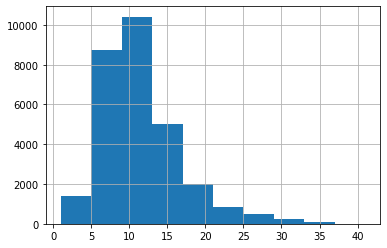

In [10]:
data['title_len'] = data['title'].apply(lambda s: len(s.split()))
data['title_len'].hist()

We prefer `max_len` to be a power of two that covers most of the titles. Here it seems 64 will do.

In [11]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 64
LINEAR_DROPOUT_RATE = 0.25
EPOCHS = 5
LEARNING_RATE = 1e-05
TRAIN_MINIBATCH_SIZE = 32
VAL_TEST_MINIBATCH_SIZE = 64
TRAIN_SET_RATIO = 0.8
VAL_SET_RATIO = 0.1
# The rest is test set
RANDOM_SEED = 123
# Flip to False for faster hyperparameter tuning. If False, only 5% of the full dataset is used. 
FULL_SET = True
PARTIAL_SET_FRAC = 0.05

CV-split our dataset:

In [12]:
small_data = None
if not FULL_SET:
    small_data = data.sample(frac = PARTIAL_SET_FRAC, random_state=RANDOM_SEED)

train_set = None
test_set = None

COLUMNS = [TEXT_COL_NAME, 'targets']

filtered = None
if FULL_SET:
    filtered = data[COLUMNS]
else:
    filtered = small_data[COLUMNS]

train_set = filtered.sample(frac = TRAIN_SET_RATIO, random_state=RANDOM_SEED)
val_test_set = filtered.drop(train_set.index)

val_set = val_test_set.sample(frac = VAL_SET_RATIO / (1-TRAIN_SET_RATIO), random_state=RANDOM_SEED)
test_set = val_test_set.drop(val_set.index)

train_set = train_set.reset_index(drop=True)
val_set = val_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(1168, 2)
(146, 2)
(146, 2)


We can now wrap them in our Datasets, and then into PyTorch's DataLoaders.

In [13]:
train_set = CustomDataset(train_set, tokenizer, MAX_LEN)
val_set = CustomDataset(val_set, tokenizer, MAX_LEN)
test_set = CustomDataset(test_set, tokenizer, MAX_LEN)

from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_set, batch_size=TRAIN_MINIBATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=val_set, batch_size=VAL_TEST_MINIBATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=test_set, batch_size=VAL_TEST_MINIBATCH_SIZE, shuffle=True, num_workers=0)

## Prepare the model itself
Here we use DistilBERT as the encoding layers, followed by a dropout layer and a linear layer for leaf category classification.

In [15]:
import torch
from tqdm.notebook import tqdm
from functools import reduce

class DistilBERTClass(torch.nn.Module):

  def __init__(self, output_count):
    super(DistilBERTClass, self).__init__()
    encoder = base_encoder
    encoder.load_state_dict(base_encoder_state)
    self.l1 = encoder
    self.l2 = torch.nn.Dropout(LINEAR_DROPOUT_RATE)
    self.l3 = torch.nn.Linear(768, output_count) # DistilBERT outputs 768 values.
    self.output_size = output_count

  def forward(self, ids, mask):
    output_1 = self.l1(ids, attention_mask = mask)[0][:,0,:]
    output_2 = self.l2(output_1)
    output = self.l3(output_2)
    return output

Now we define the loss function that we will use to fine-tune our model (DistilBERT included).

For now we'll stick with one of the provided loss functions instead of building anything radical. As we are performing multiclass classification here, we should use Cross Entropy Loss (the normal one for multiclass, not BCE for binary).

In [16]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

## Checkpoints
PyTorch allows us to save the best-performing model automatically so we can restart from that instead of the beginning. No reason not to do that.

In [17]:
import shutil, sys
def load_checkpoint(checkpoint_fpath, model, optimizer):
    """
    checkpoint_fpath: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """

    # load check point
    checkpoint = torch.load(checkpoint_fpath)

    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])

    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])

    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']

    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min

def save_checkpoint(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """

    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model (min validation lost)
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

# Training time

In [18]:
from sklearn import metrics
def get_metrics(output, targets, log_metrics = False, get_auprc = False):
    def generate_one_hot(idx):
      b = np.zeros(leaf_count, dtype=bool)
      b[idx] = 1
      return b

    # Get predicted codes
    predicted_leaf_codes = np.argmax(output, axis=1)

    acc = metrics.accuracy_score(predicted_leaf_codes, targets)
    pre = metrics.precision_score(predicted_leaf_codes, targets, average='weighted', zero_division=0)

    if log_metrics:
      logging.info('Leaf level metrics:')
      logging.info("Accuracy: {}".format(acc))
      # Model Precision: what percentage of positive tuples are labeled as such?
      logging.info("Precision: {}".format(pre))

    if get_auprc:
      # Rectified leaf AU(PRC) due to an sklearn bug.
      # We add one artificial example that belongs to all classes at once and a corresponding prediction
      # full of true positives. This way each class has at least one true positive, even if the test set
      # does not contain enough examples to cover all classes.
      binarised_targets = np.array([generate_one_hot(code) for code in targets])
      rectified_outputs = np.concatenate([output, np.ones((1, leaf_count))], axis=0)
      rectified_targets = np.concatenate([binarised_targets, np.ones((1, leaf_count), dtype=bool)], axis=0)
      auprc = metrics.average_precision_score(rectified_targets, rectified_outputs)
      if log_metrics:
        logging.info('Rectified leaf-level AU(PRC) score: {}'.format(auprc))
      return np.array([acc, pre, auprc])
    return np.array([acc, pre])

In [19]:
from tqdm.notebook import tqdm

def train_model(start_epochs, n_epochs, val_loss_min_input, 
                training_loader, val_loader, model,
                checkpoint_path, best_model_path, verbose=False):

  # Store validation metrics after each epoch
  val_metrics = np.empty((2, 0), dtype=float)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  # Keep min validation (test set) loss so we can separately back up our best-yet model
  val_loss_min = val_loss_min_input
  for epoch in range(start_epochs, n_epochs+1):
    train_loss = 0
    val_loss = 0
    # Put model into training mode. Note that this call DOES NOT train it yet.
    model.train()
    print('Epoch {}: Training'.format(epoch))
    for batch_idx, data in enumerate(tqdm(training_loader)):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      targets = data['labels'].to(device, dtype = torch.long)

      outputs = model(ids, mask)

      loss = loss_fn(outputs, targets)

      # PyTorch defaults to accumulating gradients, but we don't need that here
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss = train_loss + (loss.item() - train_loss) / (batch_idx + 1)

    print('Epoch {}: Testing'.format(epoch))
    
    
    # Switch to evaluation (prediction) mode. Again, this doesn't evaluate anything.
    model.eval()

    val_targets = np.array([], dtype=float)
    val_outputs = np.empty((0, model.output_size), dtype=float)

    # We're only testing here, so don't run the backward direction (no_grad).
    with torch.no_grad():
      total_loss = 0
      batch_count = 0
      for batch_idx, data in enumerate(tqdm(val_loader)):
        batch_count += 1
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['labels'].to(device, dtype = torch.long)

        outputs = model(ids, mask)

        loss = loss_fn(outputs, targets)

        total_loss += loss

        val_loss = val_loss + (loss.item() - val_loss) / (batch_idx + 1)
        
        val_targets = np.concatenate([val_targets, targets.cpu().detach().numpy()])
        val_outputs = np.concatenate([val_outputs, outputs.cpu().detach().numpy()])

      # calculate average losses
      #print('before cal avg train loss', train_loss)
      if verbose:
        print('Average minibatch loss:', total_loss / batch_count)
    
      val_metrics = np.concatenate([val_metrics, 
                                    np.expand_dims(get_metrics(val_outputs, val_targets), axis=1)],
                                   axis=1)
      train_loss = train_loss/len(training_loader)
      val_loss = val_loss/len(val_loader)
      # Print training/validation statistics 
      if verbose:
        print('Avgerage training loss: {:.6f}\nAverage validation loss: {:.6f}'.format( 
                train_loss,
                val_loss
                ))

      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'val_loss_min': val_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
      # save checkpoint
      best_yet = False
      if val_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min,val_loss))
        # save checkpoint as best model
        best_yet = True
        val_loss_min = val_loss
      save_checkpoint(checkpoint, best_yet, checkpoint_path, best_model_path)
    print('Epoch {}: Done\n'.format(epoch))
  return model, val_metrics

# Alternative: just load from disk
def run_model(model, loader):
  # Switch to evaluation (prediction) mode. Again, this doesn't evaluate anything.
  model.eval()

  all_targets = np.array([], dtype=int)
  all_outputs = np.empty((0, model.output_size), dtype=float)

  # We're only testing here, so don't run the backward direction (no_grad).
  with torch.no_grad():
    for batch_idx, data in enumerate(tqdm(loader)):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      targets = data['labels'].int()

      outputs = model(ids, mask)

      all_targets = np.concatenate([all_targets, targets.numpy()])
      all_outputs = np.concatenate([all_outputs, outputs.cpu().detach().numpy()])
  return {
      'targets': all_targets,
      'outputs': all_outputs,
  }

In [20]:
folder_name = 'checkpoints-avg-' + DATASET_NAME
!mkdir $folder_name
CHECKPOINT_IDX = len(os.listdir(folder_name)) // 3 # current, best, log.
logging.basicConfig(filename="{}/{}.log".format(folder_name, CHECKPOINT_IDX), level=logging.INFO)

all_test_metrics = np.zeros((TRAIN_REPEATS, 3), dtype=float)

trained_model = None
if TRAIN_FROM_SCRATCH:
    for i in range(TRAIN_REPEATS):
        run_header = "--- RUN {} ---".format(i)
        print(run_header)
        logging.info(run_header)
        # Reinitialise weights
        model = DistilBERTClass(leaf_count)
        model.to(device)
        
        # Train/validate
        CHECKPOINT_PATH = './{}/{}_{}_current.pt'.format(folder_name, CHECKPOINT_IDX, i)
        BEST_CHECKPOINT_PATH = './{}/{}_{}_best.pt'.format(folder_name, CHECKPOINT_IDX, i)
        trained_model, val_metrics = train_model(
            1, # Count from one
            EPOCHS, # EPOCH passes over our training set
            np.Inf, 
            train_loader, 
            val_loader, 
            model, 
            CHECKPOINT_PATH,
            BEST_CHECKPOINT_PATH,
        )          
        # Test
        test_result = run_model(trained_model, test_loader)
        test_metrics = get_metrics(test_result['outputs'], test_result['targets'], True, True)
        all_test_metrics[i, :] = test_metrics
    averaged = np.average(all_test_metrics, axis = 0)
    averaged_display = '--- Average of {} runs:\nLeaf accuracy: {}\nLeaf precision: {}\nLeaf AU(PRC): {}'.format(
        TRAIN_REPEATS, averaged[0], averaged[1], averaged[2])
    print(averaged_display)
    logging.info(averaged_display)
else:
    load_path = '{}/{}_{}_{}.pt'.format(folder_name, LOAD_ITERATION, TRAIN_REPEATS - 1, 'best' if LOAD_BEST else 'current')
    trained_model, _ = load_checkpoint(load_path, (encoder, classifier))
    # Test
    test_result = run_model(trained_model, test_loader)
    get_metrics(test_result['outputs'], test_result['targets'], True, True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
mkdir: cannot create directory ‘checkpoints-avg-Walmart_30k.parquet’: File exists
--- RUN 0 ---
Epoch 1: Training


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1: Testing


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss decreased (inf --> 1.588723).  Saving model ...
Epoch 1: Done



  0%|          | 0/3 [00:00<?, ?it/s]

--- RUN 1 ---
Epoch 1: Training


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1: Testing


  0%|          | 0/3 [00:00<?, ?it/s]

Validation loss decreased (inf --> 1.675605).  Saving model ...
Epoch 1: Done



  0%|          | 0/3 [00:00<?, ?it/s]

--- Average of 2 runs:
Leaf accuracy: 0.14726027397260272
Leaf precision: 0.8873124592302675
Leaf AU(PRC): 0.8976715391458174
